# Loan prediction - Model Building

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport

from sklearn.impute import KNNImputer
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn import model_selection
from sklearn.metrics import classification_report
import xgboost as xgb

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier

In [4]:
pd.set_option('max_columns', 100 )
pd.set_option('max_rows', 100 )

In [5]:
data = pd.read_csv('train_ctrUa4K.csv')
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [6]:
data.shape

(614, 13)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [8]:
data.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [9]:
data.describe(percentiles=[0.25,0.5,0.75,0.8,0.9,0.95,0.99])

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
80%,6252.400000,2535.000000,182.000000,360.00000,1.000000
90%,9459.900000,3782.200000,235.800000,360.00000,1.000000
95%,14583.000000,4997.400000,297.800000,360.00000,1.000000


In [10]:
round((data['Loan_Status'].value_counts(normalize = True)*100),2)

Y    68.73
N    31.27
Name: Loan_Status, dtype: float64

## Treating missing values :

1. Gender               13
2. Married               3
3. Dependents           15
4. Self_Employed        32
5. LoanAmount           22
6. Loan_Amount_Term     14
7. Credit_History       50

#### 1. Gender : Missing values are imputed based on weights

In [11]:
data['Gender'].isnull().sum()

13

In [12]:
round(data['Gender'].value_counts(normalize = True)*100,2)

Male      81.36
Female    18.64
Name: Gender, dtype: float64

In [13]:
gender_df = pd.DataFrame(data['Gender'].value_counts(normalize = True)*100)
gender_df.reset_index(inplace= True)
gender_df.head()

,index,Gender
0,Male,81.364393
1,Female,18.635607


In [14]:
gender_df['Increment by'] = round((gender_df['Gender']/100)* data['Gender'].isnull().sum(),0)
gender_df.columns = ['Gender','Weightage','Increment by']
gender_df

,Gender,Weightage,Increment by
0,Male,81.364393,11.0
1,Female,18.635607,2.0


In [15]:
gender_dict = dict(zip(gender_df['Gender'], gender_df['Increment by']))
gender_dict

{'Male': 11.0, 'Female': 2.0}

In [16]:
dummy_return = [data['Gender'].fillna(key, limit=int(value), inplace = True) 
              for key,value in gender_dict.items()]

In [17]:
data['Gender'].isnull().sum()

0

#### 2. Married : Missing values are imputed based on mode()

In [18]:
data['Married'].isnull().sum()

3

In [19]:
round(data['Married'].value_counts(normalize = True)*100,2)

Yes    65.14
No     34.86
Name: Married, dtype: float64

In [20]:
values = data['Married'].mode().values.tolist()
data['Married'].fillna(values[0],inplace = True)

In [21]:
data['Married'].isnull().sum()

0

#### 3. Dependants : Missing values are imputed based on weights

In [22]:
data['Dependents'].isnull().sum()

15

In [23]:
len(data[data['Dependents'] == '3+'])

51

In [24]:
data['Dependents'] = data['Dependents'].apply(lambda x : 3 if x == '3+' else x)
len(data[data['Dependents'] == 3])

51

In [25]:
dependents_df = pd.DataFrame(data['Dependents'].value_counts(normalize = True)*100)
dependents_df.reset_index(inplace= True)
dependents_df.head()

,index,Dependents
0,0,57.595993
1,1,17.028381
2,2,16.861436
3,3,8.514190


In [26]:
dependents_df['Increment by'] = round((dependents_df['Dependents']/100)* data['Dependents'].isnull().sum(),0)
dependents_df.columns = ['Dependents','Weightage','Increment by']
dependents_df

,Dependents,Weightage,Increment by
0,0,57.595993,9.0
1,1,17.028381,3.0
2,2,16.861436,3.0
3,3,8.514190,1.0


In [27]:
dependents_dict = dict(zip(dependents_df['Dependents'], dependents_df['Increment by']))
dependents_dict

{'0': 9.0, '1': 3.0, '2': 3.0, 3: 1.0}

In [28]:
dummy_return = [data['Dependents'].fillna(key, limit=int(value), inplace = True) 
              for key,value in dependents_dict.items()]

In [29]:
data['Dependents'].isnull().sum()

0

#### 4. Self Employed : Missing values are imputed based on weights

In [30]:
data['Self_Employed'].isnull().sum()

32

In [31]:
round(data['Self_Employed'].value_counts(normalize = True)*100,2)

No     85.91
Yes    14.09
Name: Self_Employed, dtype: float64

In [32]:
self_employed_df = pd.DataFrame(data['Self_Employed'].value_counts(normalize = True)*100)
self_employed_df.reset_index(inplace= True)
self_employed_df.head()

,index,Self_Employed
0,No,85.910653
1,Yes,14.089347


In [33]:
self_employed_df['Increment by'] = round((self_employed_df['Self_Employed']/100)* data['Self_Employed'].isnull().sum(),0)
self_employed_df.columns = ['Self_Employed','Weightage','Increment by']
self_employed_df

,Self_Employed,Weightage,Increment by
0,No,85.910653,27.0
1,Yes,14.089347,5.0


In [34]:
self_employed_dict = dict(zip(self_employed_df['Self_Employed'], self_employed_df['Increment by']))
self_employed_dict

{'No': 27.0, 'Yes': 5.0}

In [35]:
dummy_return = [data['Self_Employed'].fillna(key, limit=int(value), inplace = True) 
              for key,value in self_employed_dict.items()]

In [36]:
data['Self_Employed'].isnull().sum()

0

#### 5. LoanAmount, Loan_Amount_Term, Credit_History : Missing values are imputed using KNNImputer

In [37]:
data['LoanAmount'].isnull().sum()

22

In [38]:
data['Loan_Amount_Term'].isnull().sum()

14

In [39]:
data['Credit_History'].isnull().sum()

50

In [130]:
data['Credit_History'].value_counts()

1.000000    477
0.000000     87
0.666667     39
Name: Credit_History, dtype: int64

In [40]:
missing_columns = ['LoanAmount', 'Loan_Amount_Term', 'Credit_History']
data[missing_columns].head()

,LoanAmount,Loan_Amount_Term,Credit_History
0,NaN,360.0,1.0
1,128.0,360.0,1.0
2,66.0,360.0,1.0
3,120.0,360.0,1.0
4,141.0,360.0,1.0


In [41]:
imputer = KNNImputer(n_neighbors = 3)
data[missing_columns] = pd.DataFrame(imputer.fit_transform(data[missing_columns]))

In [42]:
data[missing_columns].isnull().sum()

LoanAmount          0
Loan_Amount_Term    0
Credit_History      0
dtype: int64

In [43]:
data.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [44]:
data['LoanAmount'] = data['LoanAmount'] * 1000

### Converting Categorical variables

In [45]:
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,104666.666667,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128000.000000,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66000.000000,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120000.000000,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141000.000000,360.0,1.0,Urban,Y


In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             614 non-null    object 
 2   Married            614 non-null    object 
 3   Dependents         614 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      614 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         614 non-null    float64
 9   Loan_Amount_Term   614 non-null    float64
 10  Credit_History     614 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [47]:
data['Gender'] = data['Gender'].apply(lambda x : 0 if x == 'Male' else 1)
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,0,No,0,Graduate,No,5849,0.0,104666.666667,360.0,1.0,Urban,Y
1,LP001003,0,Yes,1,Graduate,No,4583,1508.0,128000.000000,360.0,1.0,Rural,N
2,LP001005,0,Yes,0,Graduate,Yes,3000,0.0,66000.000000,360.0,1.0,Urban,Y
3,LP001006,0,Yes,0,Not Graduate,No,2583,2358.0,120000.000000,360.0,1.0,Urban,Y
4,LP001008,0,No,0,Graduate,No,6000,0.0,141000.000000,360.0,1.0,Urban,Y


In [48]:
data['Married'] = data['Married'].apply(lambda x : 0 if x == 'No' else 1)
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,0,0,0,Graduate,No,5849,0.0,104666.666667,360.0,1.0,Urban,Y
1,LP001003,0,1,1,Graduate,No,4583,1508.0,128000.000000,360.0,1.0,Rural,N
2,LP001005,0,1,0,Graduate,Yes,3000,0.0,66000.000000,360.0,1.0,Urban,Y
3,LP001006,0,1,0,Not Graduate,No,2583,2358.0,120000.000000,360.0,1.0,Urban,Y
4,LP001008,0,0,0,Graduate,No,6000,0.0,141000.000000,360.0,1.0,Urban,Y


In [49]:
data['Education'].value_counts()

Graduate        480
Not Graduate    134
Name: Education, dtype: int64

In [50]:
data['Education'] = data['Education'].apply(lambda x : 0 if x == 'Not Graduate' else 1)
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,0,0,0,1,No,5849,0.0,104666.666667,360.0,1.0,Urban,Y
1,LP001003,0,1,1,1,No,4583,1508.0,128000.000000,360.0,1.0,Rural,N
2,LP001005,0,1,0,1,Yes,3000,0.0,66000.000000,360.0,1.0,Urban,Y
3,LP001006,0,1,0,0,No,2583,2358.0,120000.000000,360.0,1.0,Urban,Y
4,LP001008,0,0,0,1,No,6000,0.0,141000.000000,360.0,1.0,Urban,Y


In [51]:
data['Self_Employed'].value_counts()

No     527
Yes     87
Name: Self_Employed, dtype: int64

In [52]:
data['Self_Employed'] = data['Self_Employed'].apply(lambda x : 0 if x == 'No' else 1)
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,0,0,0,1,0,5849,0.0,104666.666667,360.0,1.0,Urban,Y
1,LP001003,0,1,1,1,0,4583,1508.0,128000.000000,360.0,1.0,Rural,N
2,LP001005,0,1,0,1,1,3000,0.0,66000.000000,360.0,1.0,Urban,Y
3,LP001006,0,1,0,0,0,2583,2358.0,120000.000000,360.0,1.0,Urban,Y
4,LP001008,0,0,0,1,0,6000,0.0,141000.000000,360.0,1.0,Urban,Y


In [53]:
data['Property_Area'].value_counts()

Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64

In [54]:
mapping = {'Semiurban' : 0, 'Urban' : 1, 'Rural' : 2}
data['Property_Area'] = data['Property_Area'].map(mapping)
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,0,0,0,1,0,5849,0.0,104666.666667,360.0,1.0,1,Y
1,LP001003,0,1,1,1,0,4583,1508.0,128000.000000,360.0,1.0,2,N
2,LP001005,0,1,0,1,1,3000,0.0,66000.000000,360.0,1.0,1,Y
3,LP001006,0,1,0,0,0,2583,2358.0,120000.000000,360.0,1.0,1,Y
4,LP001008,0,0,0,1,0,6000,0.0,141000.000000,360.0,1.0,1,Y


In [55]:
data['Loan_Status'].value_counts()

Y    422
N    192
Name: Loan_Status, dtype: int64

In [56]:
data['Loan_Status'] = data['Loan_Status'].apply(lambda x : 0 if x == 'N' else 1)
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,0,0,0,1,0,5849,0.0,104666.666667,360.0,1.0,1,1
1,LP001003,0,1,1,1,0,4583,1508.0,128000.000000,360.0,1.0,2,0
2,LP001005,0,1,0,1,1,3000,0.0,66000.000000,360.0,1.0,1,1
3,LP001006,0,1,0,0,0,2583,2358.0,120000.000000,360.0,1.0,1,1
4,LP001008,0,0,0,1,0,6000,0.0,141000.000000,360.0,1.0,1,1


In [57]:
data['Loan_Amount_Term'].value_counts()

360.0    524
180.0     44
480.0     15
300.0     13
84.0       4
240.0      4
120.0      3
36.0       2
60.0       2
12.0       1
340.0      1
320.0      1
Name: Loan_Amount_Term, dtype: int64

In [58]:
data['Loan_Amount_Term'] = data['Loan_Amount_Term'].astype(int)
data['Loan_Amount_Term'].value_counts()

360    524
180     44
480     15
300     13
240      4
84       4
120      3
60       2
36       2
340      1
320      1
12       1
Name: Loan_Amount_Term, dtype: int64

In [59]:
loan_amount_term = pd.get_dummies(data['Loan_Amount_Term'], prefix = 'loan_term_in_months')

In [60]:
data = pd.concat([data,loan_amount_term], axis = 1)
data.drop('Loan_Amount_Term', axis = 1, inplace = True)
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Credit_History,Property_Area,Loan_Status,loan_term_in_months_12,loan_term_in_months_36,loan_term_in_months_60,loan_term_in_months_84,loan_term_in_months_120,loan_term_in_months_180,loan_term_in_months_240,loan_term_in_months_300,loan_term_in_months_320,loan_term_in_months_340,loan_term_in_months_360,loan_term_in_months_480
0,LP001002,0,0,0,1,0,5849,0.0,104666.666667,1.0,1,1,0,0,0,0,0,0,0,0,0,0,1,0
1,LP001003,0,1,1,1,0,4583,1508.0,128000.000000,1.0,2,0,0,0,0,0,0,0,0,0,0,0,1,0
2,LP001005,0,1,0,1,1,3000,0.0,66000.000000,1.0,1,1,0,0,0,0,0,0,0,0,0,0,1,0
3,LP001006,0,1,0,0,0,2583,2358.0,120000.000000,1.0,1,1,0,0,0,0,0,0,0,0,0,0,1,0
4,LP001008,0,0,0,1,0,6000,0.0,141000.000000,1.0,1,1,0,0,0,0,0,0,0,0,0,0,1,0


In [61]:
data.drop('Loan_ID', inplace = True, axis = 1)
data.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Credit_History,Property_Area,Loan_Status,loan_term_in_months_12,loan_term_in_months_36,loan_term_in_months_60,loan_term_in_months_84,loan_term_in_months_120,loan_term_in_months_180,loan_term_in_months_240,loan_term_in_months_300,loan_term_in_months_320,loan_term_in_months_340,loan_term_in_months_360,loan_term_in_months_480
0,0,0,0,1,0,5849,0.0,104666.666667,1.0,1,1,0,0,0,0,0,0,0,0,0,0,1,0
1,0,1,1,1,0,4583,1508.0,128000.000000,1.0,2,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,1,0,1,1,3000,0.0,66000.000000,1.0,1,1,0,0,0,0,0,0,0,0,0,0,1,0
3,0,1,0,0,0,2583,2358.0,120000.000000,1.0,1,1,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,1,0,6000,0.0,141000.000000,1.0,1,1,0,0,0,0,0,0,0,0,0,0,1,0


### Checking for outliers and skewness

In [62]:
numerical_columns = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']

In [63]:
print(data['ApplicantIncome'].skew())
print(data['CoapplicantIncome'].skew())
print(data['LoanAmount'].skew())

6.539513113994625
7.491531216657306
2.7413056291592053


In [64]:
data.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Credit_History,Property_Area,Loan_Status,loan_term_in_months_12,loan_term_in_months_36,loan_term_in_months_60,loan_term_in_months_84,loan_term_in_months_120,loan_term_in_months_180,loan_term_in_months_240,loan_term_in_months_300,loan_term_in_months_320,loan_term_in_months_340,loan_term_in_months_360,loan_term_in_months_480
0,0,0,0,1,0,5849,0.0,104666.666667,1.0,1,1,0,0,0,0,0,0,0,0,0,0,1,0
1,0,1,1,1,0,4583,1508.0,128000.000000,1.0,2,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,1,0,1,1,3000,0.0,66000.000000,1.0,1,1,0,0,0,0,0,0,0,0,0,0,1,0
3,0,1,0,0,0,2583,2358.0,120000.000000,1.0,1,1,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,1,0,6000,0.0,141000.000000,1.0,1,1,0,0,0,0,0,0,0,0,0,0,1,0


In [65]:
def plot_boxplot(numerical_columns):
    plt.style.use('ggplot')
    sns.set_style('whitegrid')
    plt.figure(figsize = (20,10))
    i=0

    for feature in numerical_columns:
        i += 1
        plt.subplot(3,1,i)
        plt.boxplot(x = feature, data = data)

    plt.tight_layout()    
    plt.show() 

In [66]:
def plot_histogram(numerical_columns):
    plt.style.use('ggplot')
    sns.set_style('whitegrid')    
    plt.figure(figsize = (20,10))
    i=0

    for feature in numerical_columns:
        i += 1
        plt.subplot(3,1,i)
        sns.distplot(data[feature])

    plt.tight_layout()    
    plt.show()

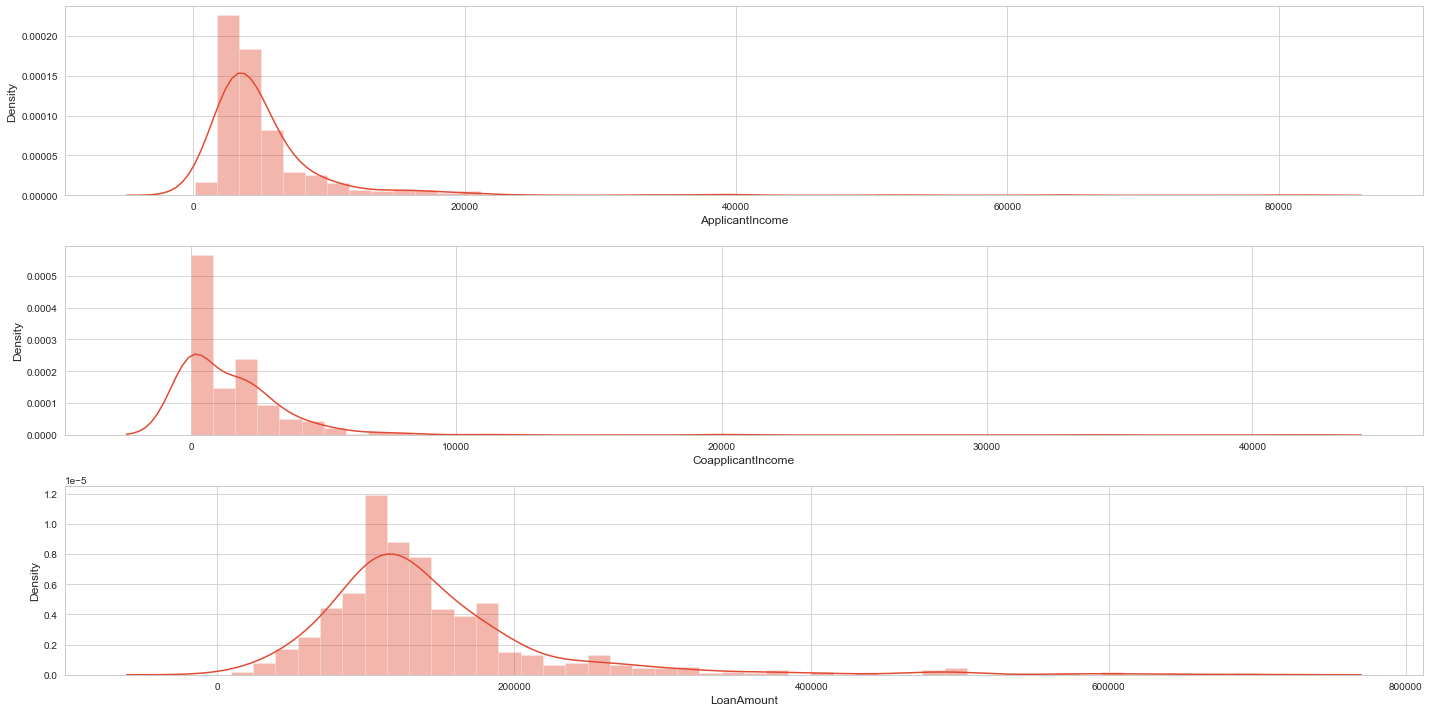

In [67]:
plot_histogram(numerical_columns)

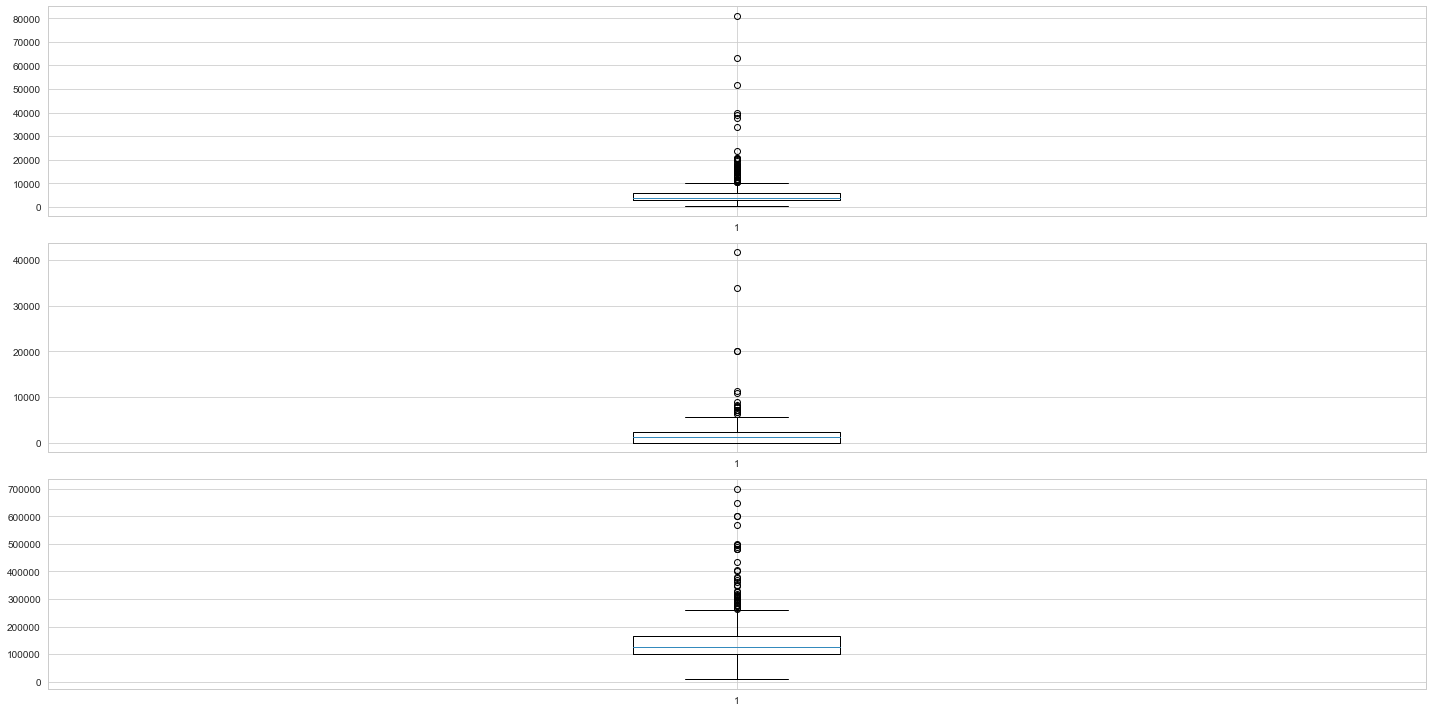

In [68]:
plot_boxplot(numerical_columns)

Converting 'CoapplicantIncome' values to 1 before applying log

In [69]:
len(data[data['CoapplicantIncome'] == 0])

273

In [70]:
transform = PowerTransformer()
data[numerical_columns] = transform.fit_transform(data[numerical_columns])
data.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Credit_History,Property_Area,Loan_Status,loan_term_in_months_12,loan_term_in_months_36,loan_term_in_months_60,loan_term_in_months_84,loan_term_in_months_120,loan_term_in_months_180,loan_term_in_months_240,loan_term_in_months_300,loan_term_in_months_320,loan_term_in_months_340,loan_term_in_months_360,loan_term_in_months_480
0,0,0,0,1,0,0.544331,-1.102837,-0.412622,1.0,1,1,0,0,0,0,0,0,0,0,0,0,1,0
1,0,1,1,1,0,0.170974,0.750578,-0.009344,1.0,2,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,1,0,1,1,-0.499955,-1.102837,-1.321115,1.0,1,1,0,0,0,0,0,0,0,0,0,0,1,0
3,0,1,0,0,0,-0.743873,0.891686,-0.139125,1.0,1,1,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,1,0,0.582817,-1.102837,0.185974,1.0,1,1,0,0,0,0,0,0,0,0,0,0,1,0


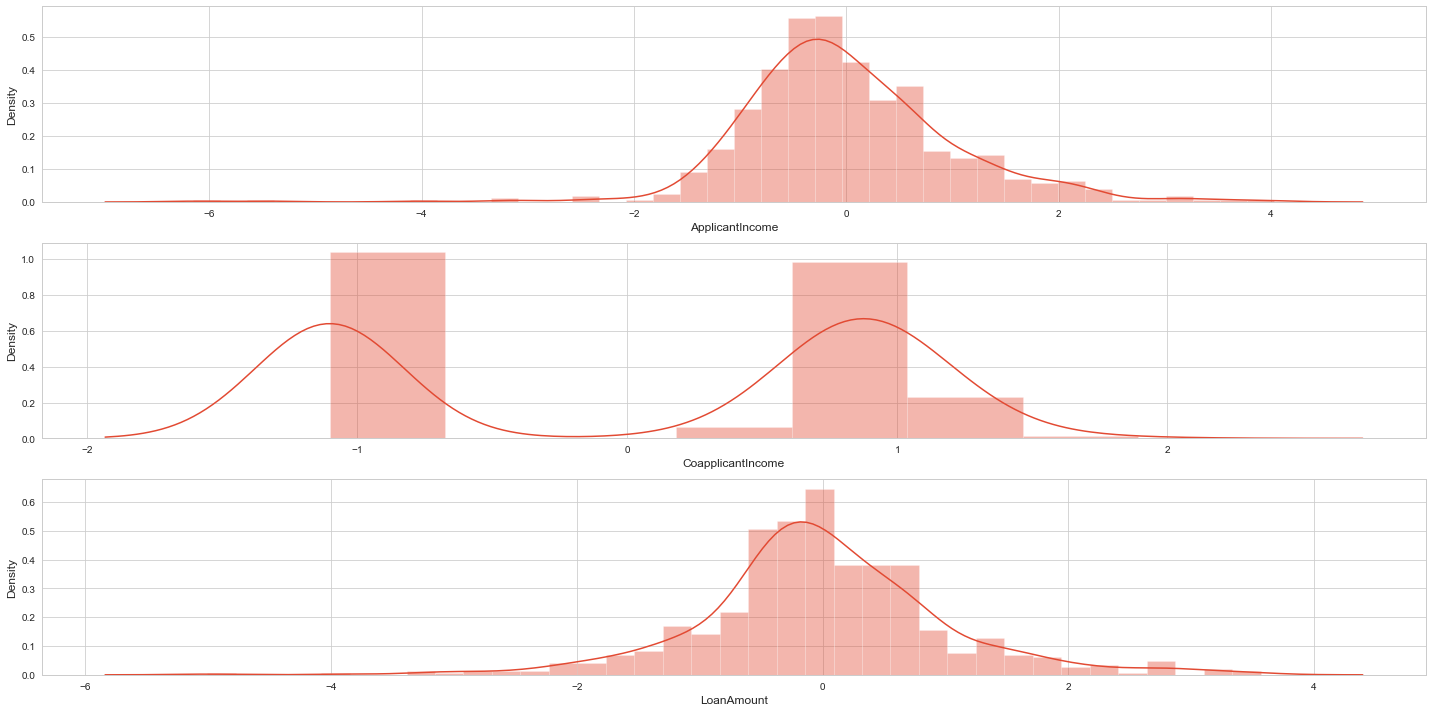

In [71]:
plot_histogram(numerical_columns)

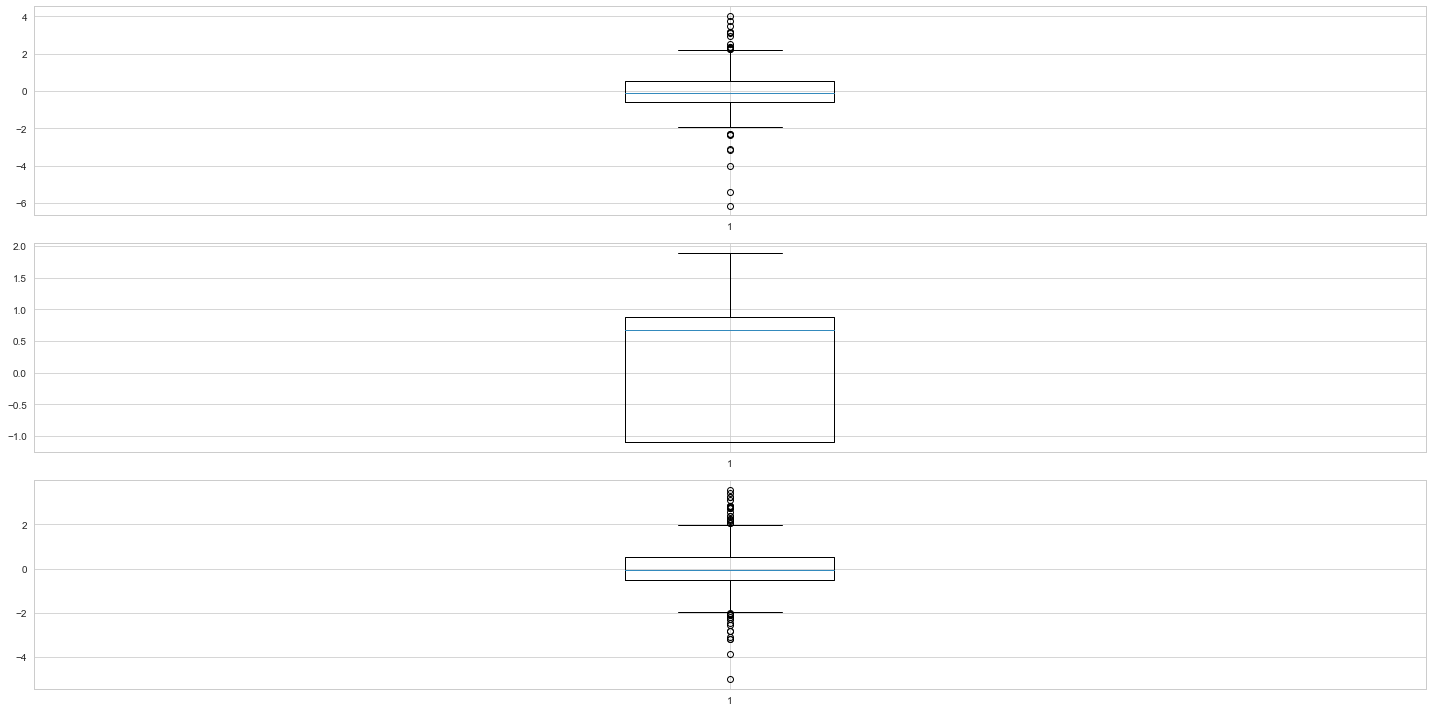

In [72]:
plot_boxplot(numerical_columns)

Removing outliers:

In [73]:
def remove_outliers(numerical_columns,data):
    for feature in numerical_columns:
        lower_critical_value = data[feature].mean() - 3 * data[feature].std()
        upper_critical_value = data[feature].mean() + 3 * data[feature].std()
        data = data[~((data[feature] < lower_critical_value) | (data[feature] > upper_critical_value))]  
        return data

In [74]:
data = remove_outliers(numerical_columns,data)
data.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Credit_History,Property_Area,Loan_Status,loan_term_in_months_12,loan_term_in_months_36,loan_term_in_months_60,loan_term_in_months_84,loan_term_in_months_120,loan_term_in_months_180,loan_term_in_months_240,loan_term_in_months_300,loan_term_in_months_320,loan_term_in_months_340,loan_term_in_months_360,loan_term_in_months_480
0,0,0,0,1,0,0.544331,-1.102837,-0.412622,1.0,1,1,0,0,0,0,0,0,0,0,0,0,1,0
1,0,1,1,1,0,0.170974,0.750578,-0.009344,1.0,2,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,1,0,1,1,-0.499955,-1.102837,-1.321115,1.0,1,1,0,0,0,0,0,0,0,0,0,0,1,0
3,0,1,0,0,0,-0.743873,0.891686,-0.139125,1.0,1,1,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,1,0,0.582817,-1.102837,0.185974,1.0,1,1,0,0,0,0,0,0,0,0,0,0,1,0


In [75]:
data.shape

(603, 23)

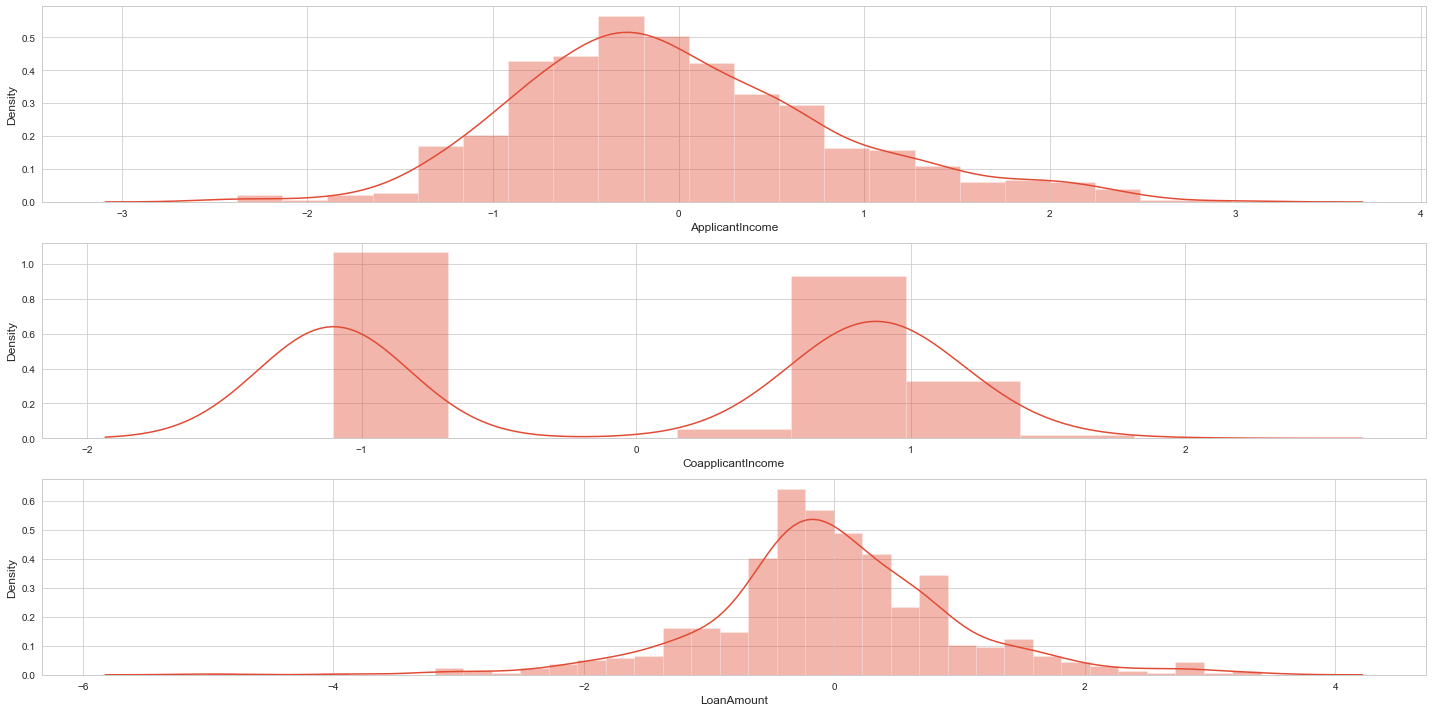

In [76]:
plot_histogram(numerical_columns)

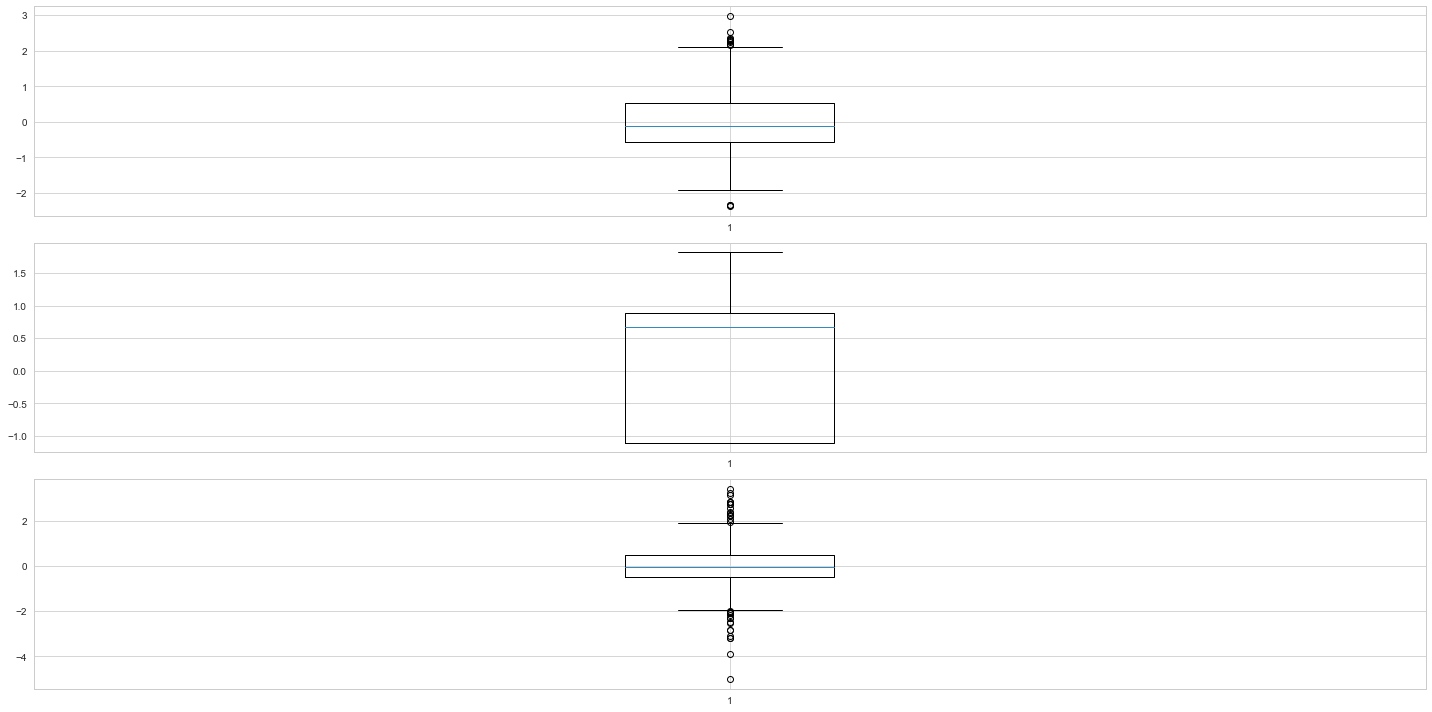

In [77]:
plot_boxplot(numerical_columns)

In [78]:
data.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Credit_History,Property_Area,Loan_Status,loan_term_in_months_12,loan_term_in_months_36,loan_term_in_months_60,loan_term_in_months_84,loan_term_in_months_120,loan_term_in_months_180,loan_term_in_months_240,loan_term_in_months_300,loan_term_in_months_320,loan_term_in_months_340,loan_term_in_months_360,loan_term_in_months_480
0,0,0,0,1,0,0.544331,-1.102837,-0.412622,1.0,1,1,0,0,0,0,0,0,0,0,0,0,1,0
1,0,1,1,1,0,0.170974,0.750578,-0.009344,1.0,2,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,1,0,1,1,-0.499955,-1.102837,-1.321115,1.0,1,1,0,0,0,0,0,0,0,0,0,0,1,0
3,0,1,0,0,0,-0.743873,0.891686,-0.139125,1.0,1,1,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,1,0,0.582817,-1.102837,0.185974,1.0,1,1,0,0,0,0,0,0,0,0,0,0,1,0


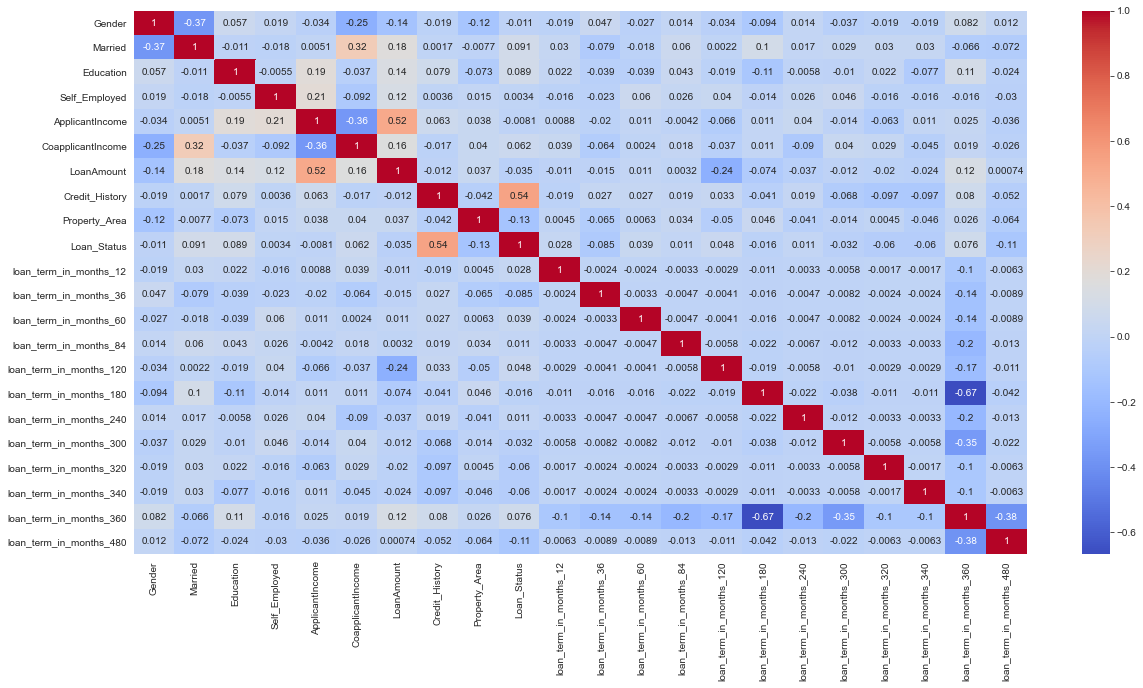

In [79]:
plt.figure(figsize = (20,10))
sns.heatmap(data.corr(),annot=True, cmap = 'coolwarm')
plt.show()

## Feature Selection

In [80]:
prof = ProfileReport(data)
prof.to_file(output_file='report.html')

## Treating class imbalance

1. Random Over Sampling
2. SMOTE

   Models:
   

1. Logistic Regression
2. Naive Bayes
3. Random Forest
4. XGBoost

In [81]:
# ROC Curve function
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(15, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [82]:
y = data.pop('Loan_Status')
X = data

In [1]:
plt.figure(figsize=(15,8))
model = ExtraTreesClassifier()
model.fit(X,y)

#plot graph of feature importances
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.save_fig()
plt.show()

NameError: name 'plt' is not defined

In [84]:
(feat_importances.nlargest(10).index).to_list()

['Credit_History',
 'ApplicantIncome',
 'LoanAmount',
 'CoapplicantIncome',
 'Dependents',
 'Property_Area',
 'Self_Employed',
 'Gender',
 'Education',
 'Married']

In [85]:
X = X[(feat_importances.nlargest(10).index).to_list()]

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 101)
y_train = y_train.values.reshape(-1,1)
y_test = y_test.values.reshape(-1,1)

In [87]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(482, 10)
(482, 1)
(121, 10)
(121, 1)


#### Random Over Sampler

In [88]:
from imblearn.over_sampling import RandomOverSampler

# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
X_over, y_over = oversample.fit_resample(X_train, y_train)

#### SMOTE

In [89]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=0)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

### Model 1: Logistic Regression : Random Oversampling

In [90]:
logistic_model = LogisticRegression()

# Default-Run of default-hyperparameters
parameters = {"C": [0.01, 0.1, 1, 10, 100, 1000]}

scorer = metrics.make_scorer(metrics.roc_auc_score,
                             greater_is_better=True,
                             needs_proba=True,
                             needs_threshold=False)

logistic_model = model_selection.GridSearchCV(estimator=logistic_model,
                                       param_grid=parameters,
                                       n_jobs=-1,
                                       cv=3,
                                       scoring=scorer,
                                       refit=True)

logistic_model.fit(X_over, y_over)

GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000]},
             scoring=make_scorer(roc_auc_score, needs_proba=True))

In [91]:
print(logistic_model.best_params_)

{'C': 100}


In [92]:
logistic_model = LogisticRegression(C=100)

logistic_model.fit(X_over, y_over)
predictions = logistic_model.predict(X_test)

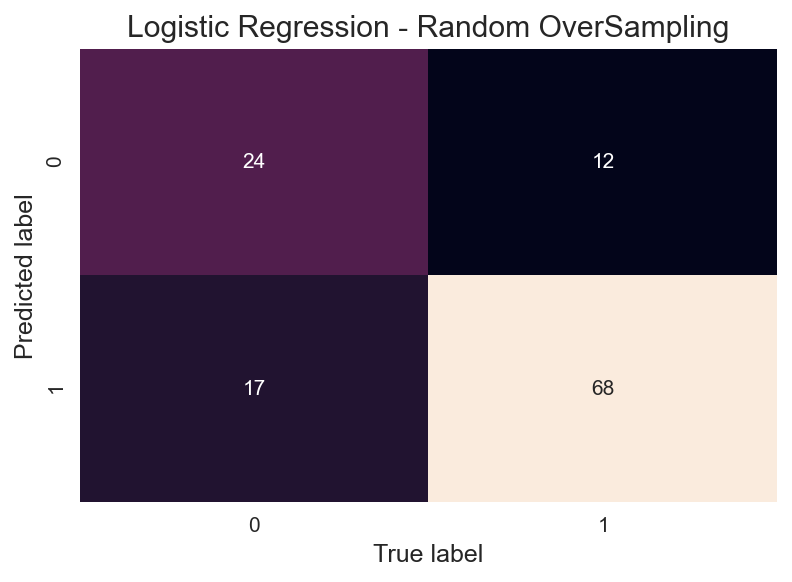

In [93]:
from sklearn.metrics import confusion_matrix

plt.figure(dpi=150)
mat = confusion_matrix(y_test, predictions)
sns.heatmap(mat.T, annot=True, fmt='d', cbar=False)

plt.title('Logistic Regression - Random OverSampling')
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.show()

In [94]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.67      0.59      0.62        41
           1       0.80      0.85      0.82        80

    accuracy                           0.76       121
   macro avg       0.73      0.72      0.72       121
weighted avg       0.75      0.76      0.76       121



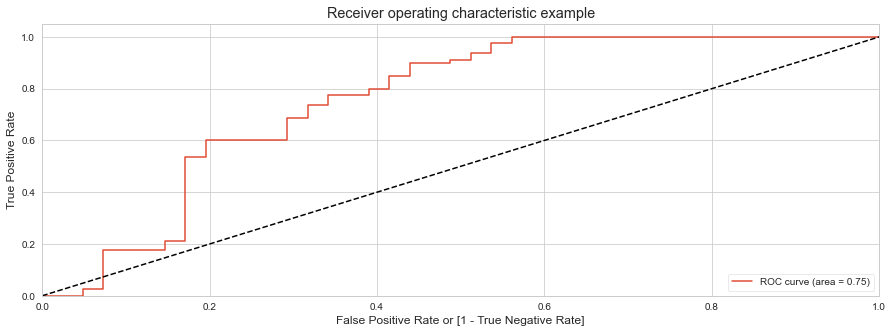

In [95]:
# Predicted probability
y_test_pred_proba = logistic_model.predict_proba(X_test)[:,1]

# Plot the ROC curve
draw_roc(y_test, y_test_pred_proba)

### Model 2: Logistic Regression : SMOTE

In [96]:
logistic_model = LogisticRegression()

# Default-Run of default-hyperparameters
parameters = {"C": [0.01, 0.1, 1, 10, 100, 1000]}

scorer = metrics.make_scorer(metrics.roc_auc_score,
                             greater_is_better=True,
                             needs_proba=True,
                             needs_threshold=False)

logistic_model = model_selection.GridSearchCV(estimator=logistic_model,
                                       param_grid=parameters,
                                       n_jobs=-1,
                                       cv=3,
                                       scoring=scorer,
                                       refit=True)

logistic_model.fit(X_train_smote, y_train_smote)

GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000]},
             scoring=make_scorer(roc_auc_score, needs_proba=True))

In [97]:
print(logistic_model.best_params_)

{'C': 1}


In [98]:
logistic_model = LogisticRegression(C=1)

logistic_model.fit(X_train_smote, y_train_smote)
predictions = logistic_model.predict(X_test)

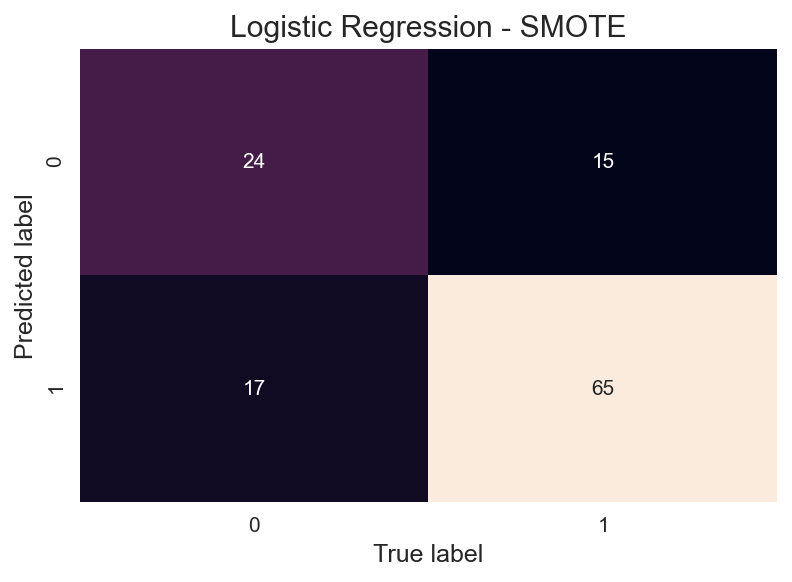

In [99]:
from sklearn.metrics import confusion_matrix

plt.figure(dpi=150)
mat = confusion_matrix(y_test, predictions)
sns.heatmap(mat.T, annot=True, fmt='d', cbar=False)

plt.title('Logistic Regression - SMOTE')
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.show()

In [100]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.62      0.59      0.60        41
           1       0.79      0.81      0.80        80

    accuracy                           0.74       121
   macro avg       0.70      0.70      0.70       121
weighted avg       0.73      0.74      0.73       121



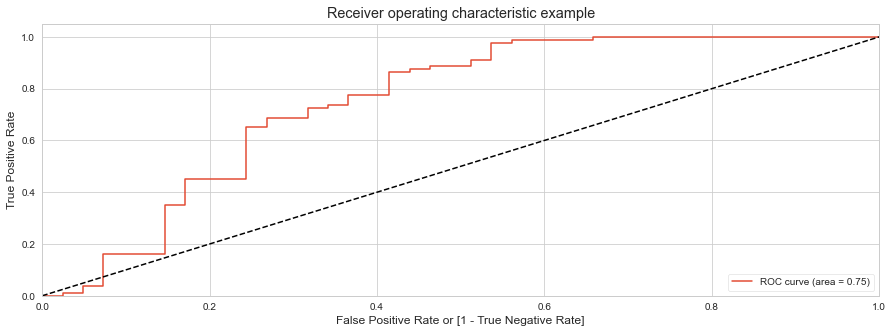

In [101]:
# Predicted probability
y_test_pred_proba = logistic_model.predict_proba(X_test)[:,1]

# Plot the ROC curve
draw_roc(y_test, y_test_pred_proba)

### Model 3 : Random Forest : Random Oversampling

In [119]:
#Number of trees in random forest:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]

#Number of features to consider at every split:
max_features = ['auto', 'sqrt']

#Maximum number of levels in tree:
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]

#Minimum number of samples required to split a node :
min_samples_split = [2, 5, 10, 15, 100]

#Minimum number of samples required at each leaf node :
min_samples_leaf = [1, 2, 5, 10]

In [120]:
#Setting the random grid :
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

print(param_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 10, 15, 20, 25, 30], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [1, 2, 5, 10]}


In [121]:
random_forests = RandomForestClassifier()

random_forests_random = RandomizedSearchCV(estimator = random_forests, param_distributions = param_grid,
                               scoring='neg_mean_squared_error', n_iter = 10, cv = 5, verbose=2, 
                               random_state=42, n_jobs = -1)

In [122]:
random_forests_random.fit(X_over,y_over)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [123]:
random_forests_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 25}

In [124]:
random_forests = RandomForestClassifier( n_estimators = 1000,
                                         min_samples_split = 2,
                                         min_samples_leaf = 1,
                                         max_features = 'sqrt',
                                         max_depth = 25,
                                         random_state = 101)

In [125]:
random_forests = random_forests.fit(X_over,y_over)
predictions=random_forests.predict(X_test)

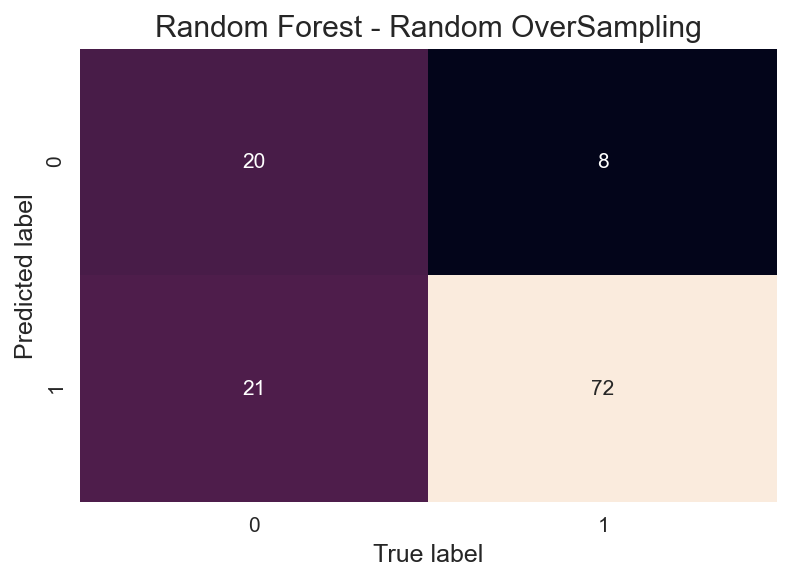

In [126]:
from sklearn.metrics import confusion_matrix

plt.figure(dpi=150)
mat = confusion_matrix(y_test, predictions)
sns.heatmap(mat.T, annot=True, fmt='d', cbar=False)

plt.title('Random Forest - Random OverSampling')
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.show()

In [127]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.71      0.49      0.58        41
           1       0.77      0.90      0.83        80

    accuracy                           0.76       121
   macro avg       0.74      0.69      0.71       121
weighted avg       0.75      0.76      0.75       121



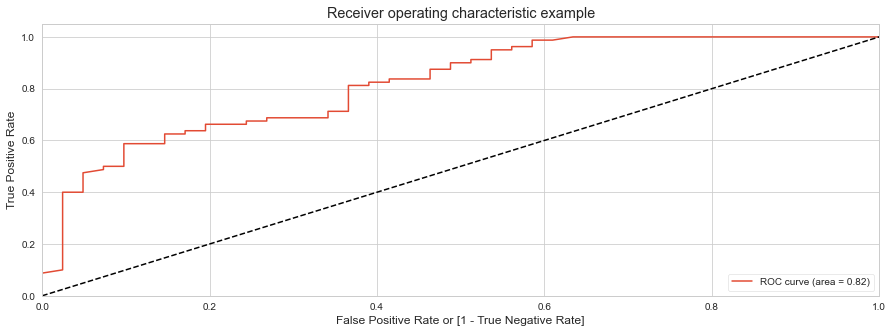

In [128]:
# Predicted probability
y_test_pred_proba = random_forests.predict_proba(X_test)[:,1]

# Plot the ROC curve
draw_roc(y_test, y_test_pred_proba)

### Model 4 : Random Forest : SMOTE

In [112]:
random_forests_random.fit(X_train_smote,y_train_smote)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [113]:
random_forests_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 25}

In [114]:
random_forests = RandomForestClassifier( n_estimators = 1000,
                                         min_samples_split = 2,
                                         min_samples_leaf = 1,
                                         max_features = 'sqrt',
                                         max_depth = 25,
                                         random_state = 101)

In [115]:
random_forests = random_forests.fit(X_train_smote,y_train_smote)
predictions=random_forests.predict(X_test)

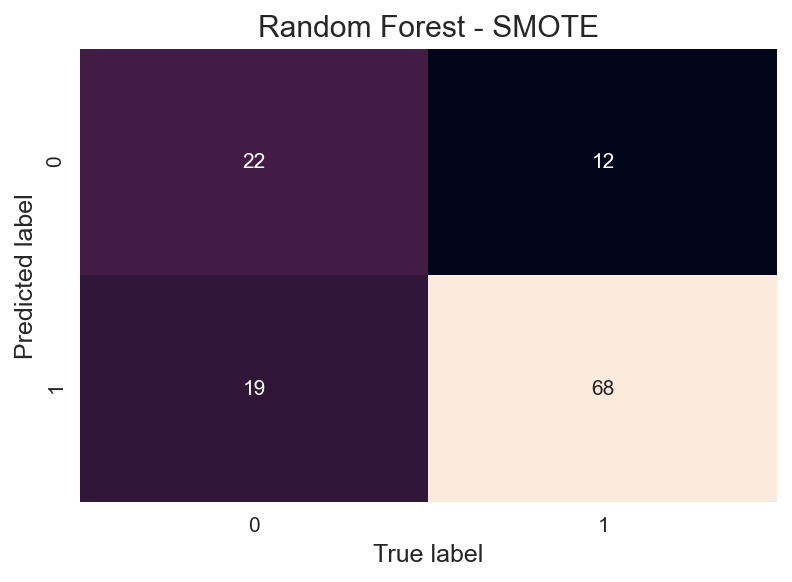

In [116]:
from sklearn.metrics import confusion_matrix

plt.figure(dpi=150)
mat = confusion_matrix(y_test, predictions)
sns.heatmap(mat.T, annot=True, fmt='d', cbar=False)

plt.title('Random Forest - SMOTE')
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.show()

In [117]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.65      0.54      0.59        41
           1       0.78      0.85      0.81        80

    accuracy                           0.74       121
   macro avg       0.71      0.69      0.70       121
weighted avg       0.74      0.74      0.74       121



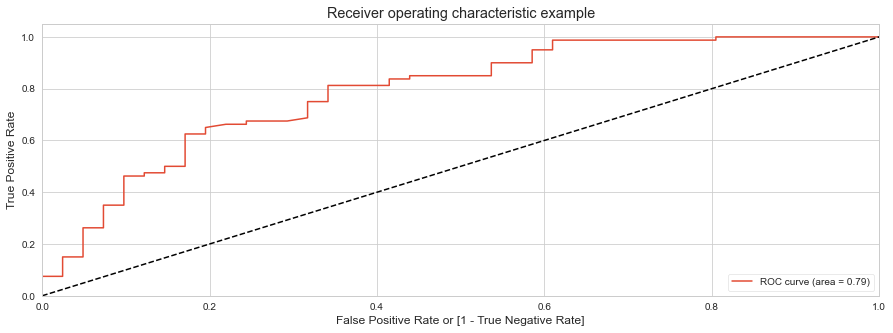

In [118]:
# Predicted probability
y_test_pred_proba = random_forests.predict_proba(X_test)[:,1]

# Plot the ROC curve
draw_roc(y_test, y_test_pred_proba)

In [129]:
import pickle
with open("random_forests", "wb") as f:
    pickle.dump(random_forests, f)